# Pairs Trading — Analyse complète

Notebook d'exploration et de visualisation du projet de pairs trading.
Exécuter les cellules dans l'ordre pour reproduire l'intégralité du pipeline.

In [1]:
import sys, os
sys.path.insert(0, '../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

sns.set_theme(style='darkgrid', palette='muted')
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['figure.dpi']    = 110

print('Imports OK')

Imports OK


## Étape 1 — Données

[data_loader] Téléchargement de 16 tickers de 2015-01-01 à 2024-12-31 …


[*********************100%***********************]  16 of 16 completed


[data_loader] 2515 jours × 16 tickers téléchargés.
[data_loader] Données propres : 2515 jours × 16 tickers.
[data_loader] Train : 2018-12-31 → 2023-12-29 (1259 jours)
[data_loader] Test  : 2024-01-02  → 2024-12-30 (251 jours)


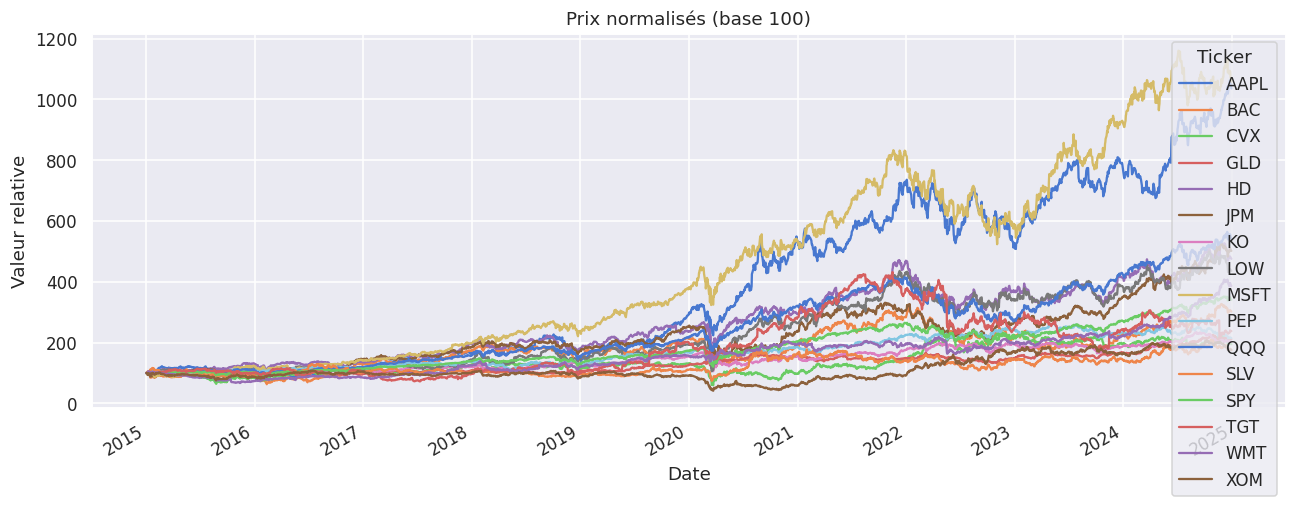

In [2]:
from data_loader import download_prices, clean_prices, train_test_split

prices = clean_prices(download_prices())
train, test = train_test_split(prices)

# Normalisation des prix (base 100) pour visualiser la co-évolution
norm = prices / prices.iloc[0] * 100
norm.plot(legend=True, title='Prix normalisés (base 100)')
plt.ylabel('Valeur relative')
plt.show()

## Étape 2 — Sélection des paires cointégrées

In [3]:
from cointegration import find_cointegrated_pairs

pairs_df = find_cointegrated_pairs(train)
display(pairs_df.style.format({'pvalue': '{:.4f}', 'beta': '{:.4f}', 'halflife': '{:.1f}'}))

[cointegration] Test de 120 paires …
[cointegration] 4 paires cointégrées trouvées (seuil p=0.05, hl=[5.0,120.0] jours).


,ticker_y,ticker_x,pvalue,alpha,beta,halflife
0,GLD,WMT,0.0073,53.633718,2.5907,27.7
1,AAPL,WMT,0.0179,-164.662777,6.7551,32.2
2,LOW,SPY,0.0380,-79.982694,0.6746,32.0
3,AAPL,LOW,0.0421,-32.284955,0.9669,37.1


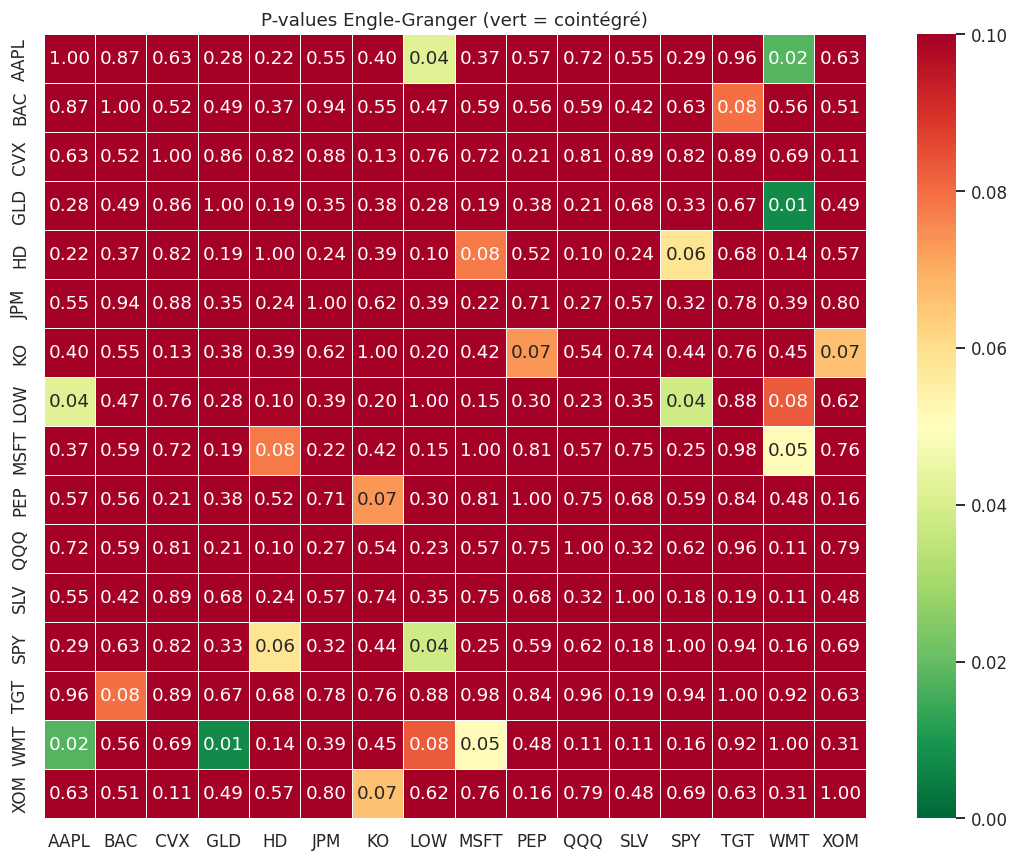

In [4]:
# Heatmap des p-values Engle-Granger
from itertools import combinations
from statsmodels.tsa.stattools import coint

tickers = train.columns.tolist()
pval_matrix = pd.DataFrame(np.ones((len(tickers), len(tickers))),
                            index=tickers, columns=tickers)

for y, x in combinations(tickers, 2):
    try:
        _, p, _ = coint(train[y], train[x])
        pval_matrix.loc[y, x] = p
        pval_matrix.loc[x, y] = p
    except:
        pass

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(pval_matrix, annot=True, fmt='.2f', cmap='RdYlGn_r',
            vmin=0, vmax=0.1, ax=ax, linewidths=0.5)
ax.set_title('P-values Engle-Granger (vert = cointégré)')
plt.tight_layout()
plt.savefig('../results/pvalue_heatmap.png', dpi=150)
plt.show()

## Étapes 3-4 — Spread et Z-score

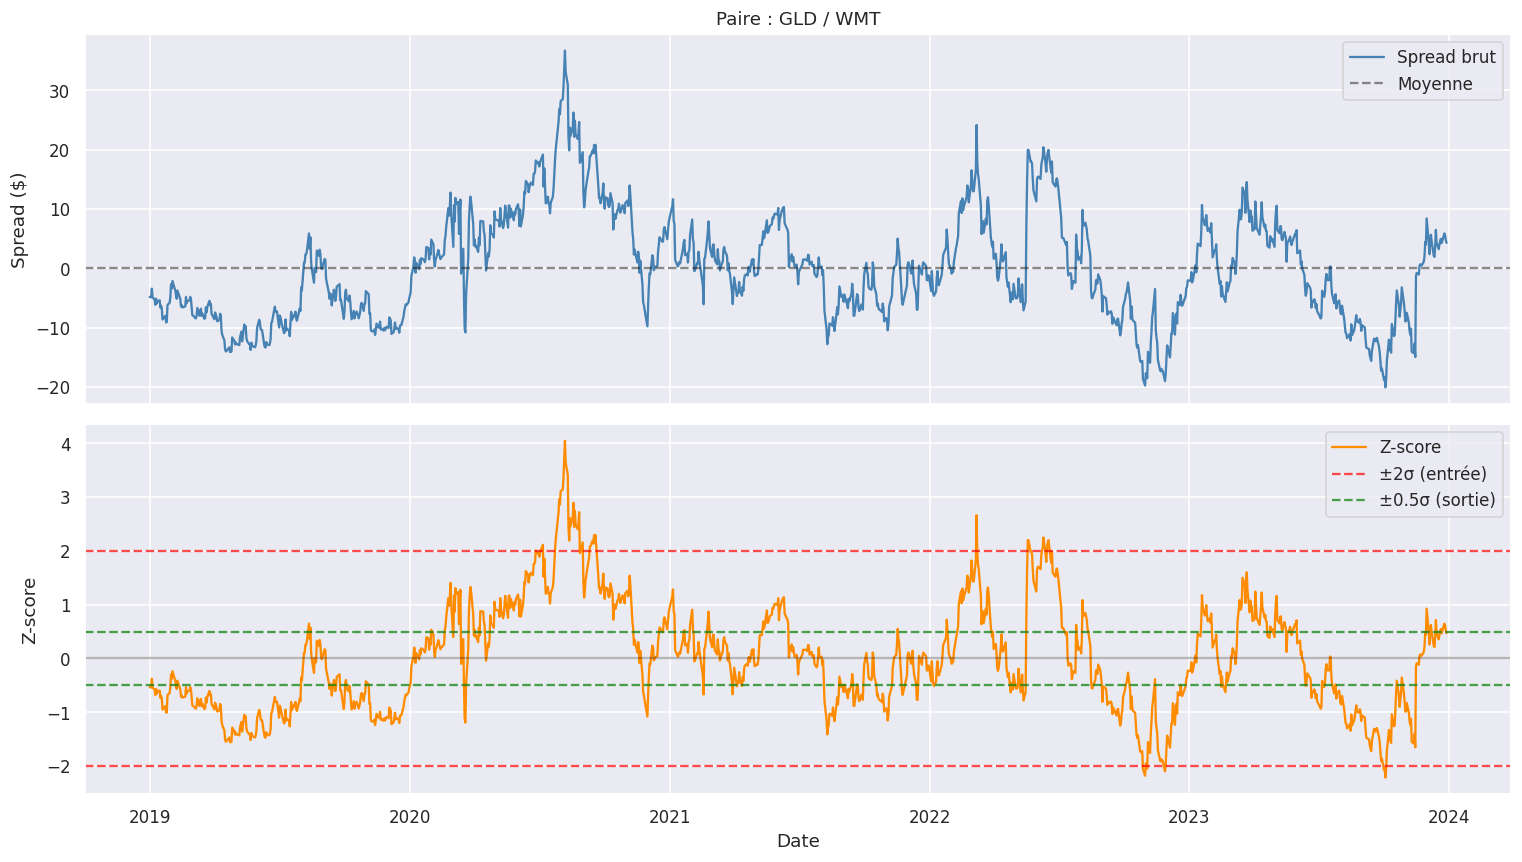

In [5]:
from cointegration import compute_spread
from signals import generate_signal

best = pairs_df.iloc[0]
spread_df = compute_spread(train, best['ticker_y'], best['ticker_x'],
                           best['alpha'], best['beta'])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Spread brut
ax1.plot(spread_df['spread'], label='Spread brut', color='steelblue')
ax1.axhline(spread_df['spread'].mean(), color='k', linestyle='--', alpha=0.5, label='Moyenne')
ax1.set_ylabel('Spread ($)')
ax1.set_title(f"Paire : {best['ticker_y']} / {best['ticker_x']}")
ax1.legend()

# Z-score avec seuils de trading
ax2.plot(spread_df['zscore'], label='Z-score', color='darkorange')
ax2.axhline( 2.0, color='red',   linestyle='--', alpha=0.7, label='±2σ (entrée)')
ax2.axhline(-2.0, color='red',   linestyle='--', alpha=0.7)
ax2.axhline( 0.5, color='green', linestyle='--', alpha=0.7, label='±0.5σ (sortie)')
ax2.axhline(-0.5, color='green', linestyle='--', alpha=0.7)
ax2.axhline( 0.0, color='k',     linestyle='-',  alpha=0.3)
ax2.set_ylabel('Z-score')
ax2.set_xlabel('Date')
ax2.legend()

plt.tight_layout()
plt.savefig('../results/spread_zscore.png', dpi=150)
plt.show()

## Étape 5 — Backtest

[backtester] Backtest de la paire (GLD, WMT) …
[backtester] PnL total : 262,642 $


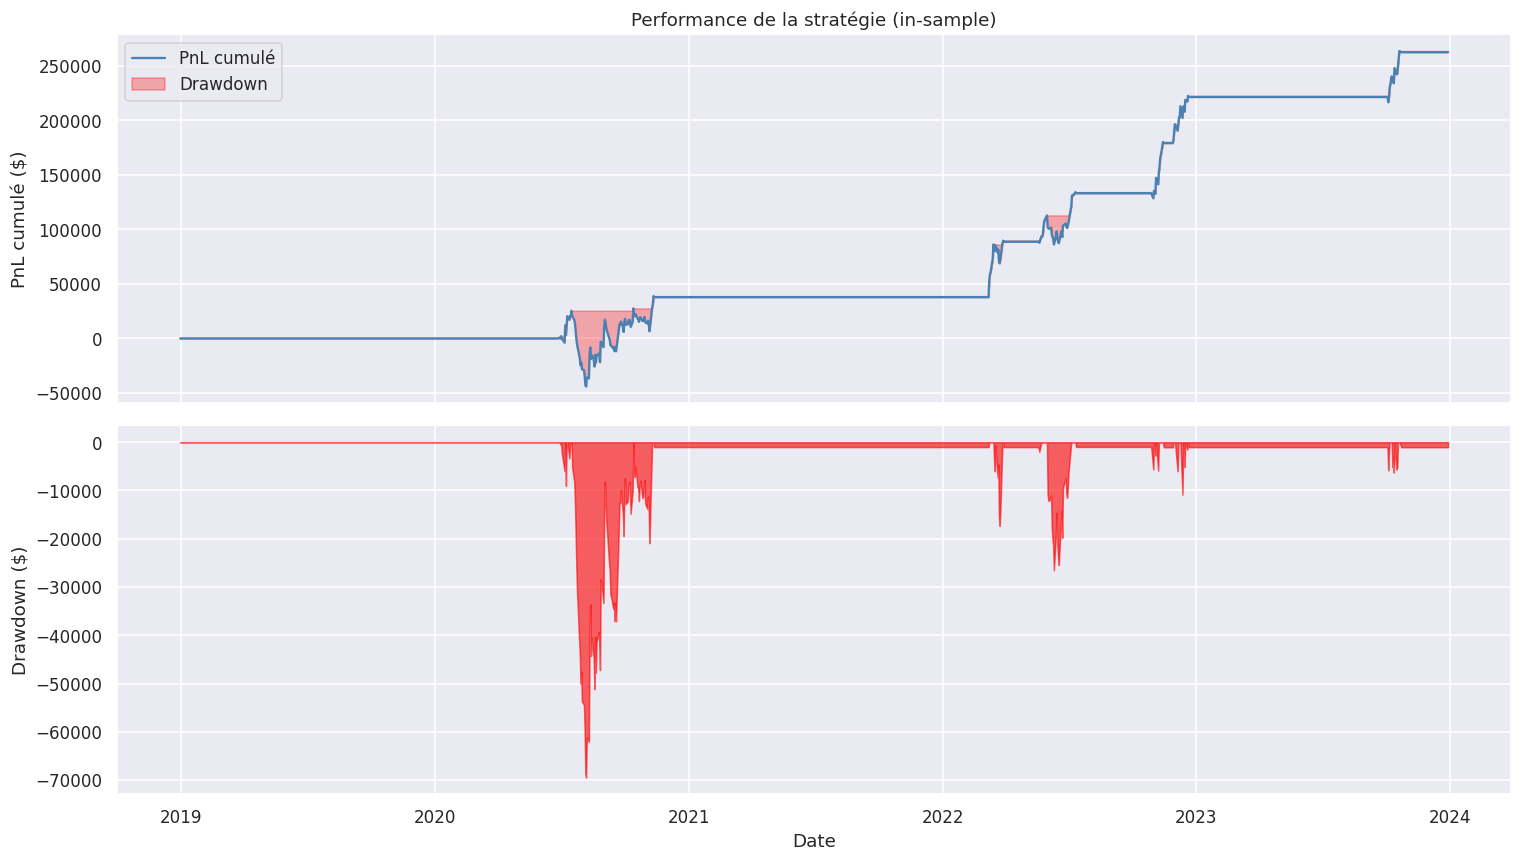

In [6]:
from backtester import Backtester

CAPITAL = 1_000_000.0

bt = Backtester(initial_capital=CAPITAL)
bt.add_pair(train, best['ticker_y'], best['ticker_x'],
            best['alpha'], best['beta'], capital_alloc=CAPITAL)
results = bt.run()

# PnL cumulé
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

cumulative = results['cumulative_pnl']
ax1.plot(cumulative, label='PnL cumulé', color='steelblue')
ax1.fill_between(cumulative.index,
                 cumulative.cummax(),
                 cumulative,
                 alpha=0.3, color='red', label='Drawdown')
ax1.set_ylabel('PnL cumulé ($)')
ax1.set_title('Performance de la stratégie (in-sample)')
ax1.legend()

# Drawdown
drawdown = cumulative - cumulative.cummax()
ax2.fill_between(drawdown.index, drawdown, 0, color='red', alpha=0.6)
ax2.set_ylabel('Drawdown ($)')
ax2.set_xlabel('Date')

plt.tight_layout()
plt.savefig('../results/pnl_backtest.png', dpi=150)
plt.show()

## Étape 6 — Métriques

In [7]:
from metrics import compute_all_metrics, print_metrics

metrics = compute_all_metrics(
    pnl=results['portfolio_pnl'],
    exposure=results['exposure'],
    initial_capital=CAPITAL,
)
print_metrics(metrics)


  PERFORMANCE METRICS
  Sharpe ratio (annuel)                   1.2810
  Sortino ratio (annuel)                  1.1496
  Max drawdown ($)                    -69486.2629
  Durée max drawdown (jours)                 331
  Calmar ratio                            0.7566
  Hit ratio                               0.5000
  PnL total ($)                       262642.4891
  PnL moyen quotidien ($)               208.6120
  Volatilité journalière ($)           2585.1364
  Exposition moyenne                      0.1202
  Nombre de jours                           1259



## Étape 7 — Bootstrap du Sharpe

[bootstrap] Block bootstrap : B=1000, block_length=10, T=1259 …
[bootstrap] Sharpe observé : 1.281
[bootstrap] IC 95% : [0.429, 2.098]
[bootstrap] P-value (H0: SR≤0) : 0.0020


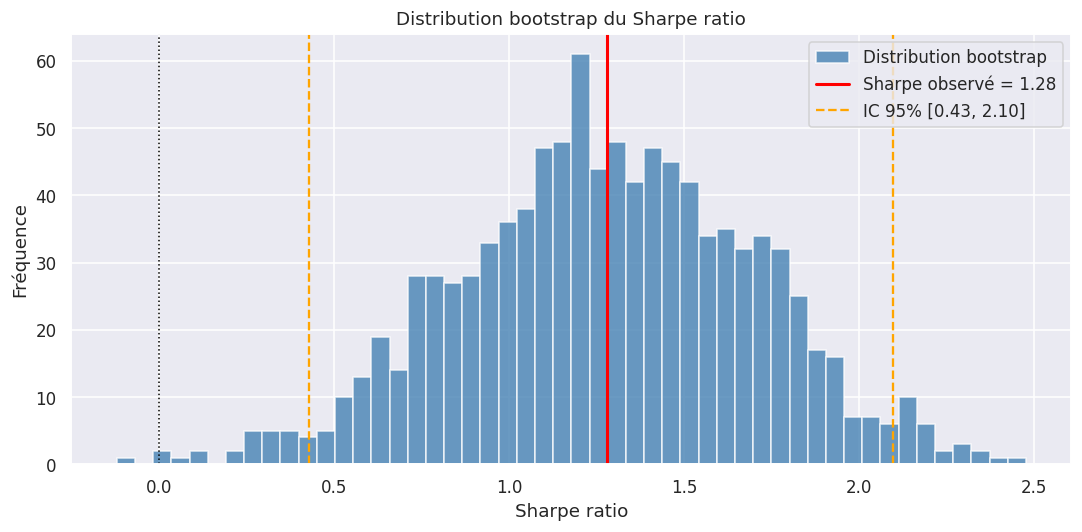


Significatif à 5% (bootstrap) : True
P-value : 0.0020
Lo (2002) — t-stat : 13.92, p-value : 0.0000


In [8]:
from bootstrap import bootstrap_sharpe, sharpe_significance_lo2002

boot = bootstrap_sharpe(results['portfolio_pnl'], n_bootstrap=1000)

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(boot['sharpe_bootstrap'], bins=50, color='steelblue', edgecolor='white',
        alpha=0.8, label='Distribution bootstrap')
ax.axvline(boot['sharpe_observed'], color='red',   linewidth=2,
           label=f"Sharpe observé = {boot['sharpe_observed']:.2f}")
ax.axvline(boot['ci_lower'],        color='orange', linewidth=1.5, linestyle='--',
           label=f"IC 95% [{boot['ci_lower']:.2f}, {boot['ci_upper']:.2f}]")
ax.axvline(boot['ci_upper'],        color='orange', linewidth=1.5, linestyle='--')
ax.axvline(0, color='black', linewidth=1, linestyle=':')
ax.set_xlabel('Sharpe ratio')
ax.set_ylabel('Fréquence')
ax.set_title('Distribution bootstrap du Sharpe ratio')
ax.legend()
plt.tight_layout()
plt.savefig('../results/bootstrap_sharpe.png', dpi=150)
plt.show()

print(f"\nSignificatif à 5% (bootstrap) : {boot['is_significant']}")
print(f"P-value : {boot['pvalue']:.4f}")

lo = sharpe_significance_lo2002(results['portfolio_pnl'])
print(f"Lo (2002) — t-stat : {lo['t_stat']:.2f}, p-value : {lo['pvalue_lo2002']:.4f}")

## Étape 9 — Monte Carlo du PnL

[monte_carlo] Estimation des paramètres OU …
[monte_carlo] OU params : κ=0.0250, μ=0.2862, σ=2.0174, hl=27.7 jours
[monte_carlo] Simulation de 2000 trajectoires sur 252 jours …
[monte_carlo] PnL moyen : 10.53
[monte_carlo] Frac. trajectoires rentables : 62.6%
[monte_carlo] VaR 5% : 0.00   CVaR 5% : -0.59


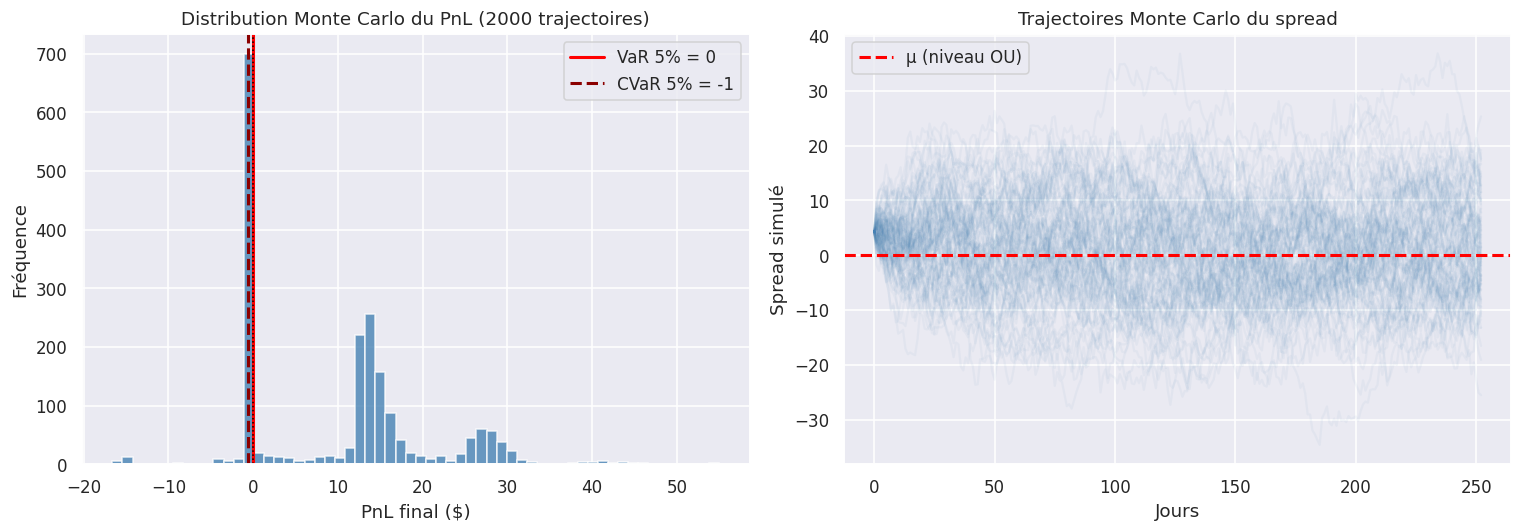

Fraction de trajectoires rentables : 62.6%
VaR 5% : 0.00 | CVaR 5% : -0.59


In [9]:
from monte_carlo import run_monte_carlo

mc = run_monte_carlo(
    spread=spread_df['spread'],
    n_paths=2000,
    horizon_days=252,
)

# Distribution du PnL final Monte Carlo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(mc['pnl_distribution'], bins=60, color='steelblue',
         edgecolor='white', alpha=0.8)
ax1.axvline(mc['var_5pct'],  color='red',    linewidth=2,
            label=f"VaR 5% = {mc['var_5pct']:.0f}")
ax1.axvline(mc['cvar_5pct'], color='darkred', linewidth=2, linestyle='--',
            label=f"CVaR 5% = {mc['cvar_5pct']:.0f}")
ax1.axvline(0, color='black', linewidth=1, linestyle=':')
ax1.set_xlabel('PnL final ($)')
ax1.set_ylabel('Fréquence')
ax1.set_title(f'Distribution Monte Carlo du PnL ({mc["n_paths"]} trajectoires)')
ax1.legend()

# Quelques trajectoires OU simulées
n_display = min(100, mc['n_paths'])
for i in range(n_display):
    ax2.plot(mc['spread_paths'][i], alpha=0.05, color='steelblue')
ax2.axhline(spread_df['spread'].mean(), color='red', linewidth=2,
            linestyle='--', label='μ (niveau OU)')
ax2.set_xlabel('Jours')
ax2.set_ylabel('Spread simulé')
ax2.set_title('Trajectoires Monte Carlo du spread')
ax2.legend()

plt.tight_layout()
plt.savefig('../results/monte_carlo.png', dpi=150)
plt.show()

print(f"Fraction de trajectoires rentables : {mc['pct_positive']:.1%}")
print(f"VaR 5% : {mc['var_5pct']:.2f} | CVaR 5% : {mc['cvar_5pct']:.2f}")

## Étape 8 — Walk-Forward Analysis

[data_loader] 4 fenêtres walk-forward générées.
[walk_forward] 4 fenêtres à backtester …

[walk_forward] Fenêtre 1/4 : train [2015-01-02 → 2019-12-31], test [2020-01-02 → 2020-12-31]
[cointegration] Test de 120 paires …
[cointegration] 8 paires cointégrées trouvées (seuil p=0.05, hl=[5.0,120.0] jours).
[backtester] Backtest de la paire (LOW, MSFT) …
[backtester] Backtest de la paire (QQQ, SPY) …
[backtester] Backtest de la paire (LOW, WMT) …
[backtester] PnL total : 202,814 $

[walk_forward] Fenêtre 2/4 : train [2016-01-04 → 2020-12-31], test [2021-01-04 → 2021-12-31]
[cointegration] Test de 120 paires …
[cointegration] 11 paires cointégrées trouvées (seuil p=0.05, hl=[5.0,120.0] jours).
[backtester] Backtest de la paire (GLD, XOM) …
[backtester] Backtest de la paire (HD, WMT) …
[backtester] Backtest de la paire (MSFT, WMT) …
[backtester] PnL total : 115,022 $

[walk_forward] Fenêtre 3/4 : train [2017-01-03 → 2021-12-31], test [2022-01-03 → 2022-12-30]
[cointegration] Test de 120 paire

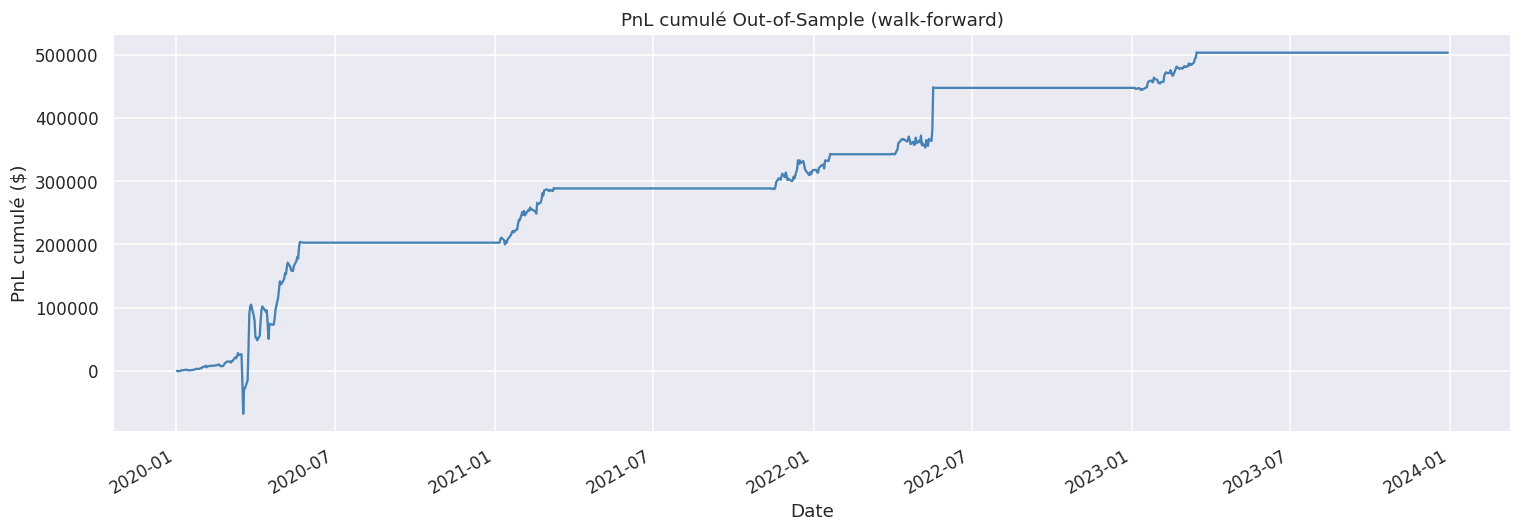

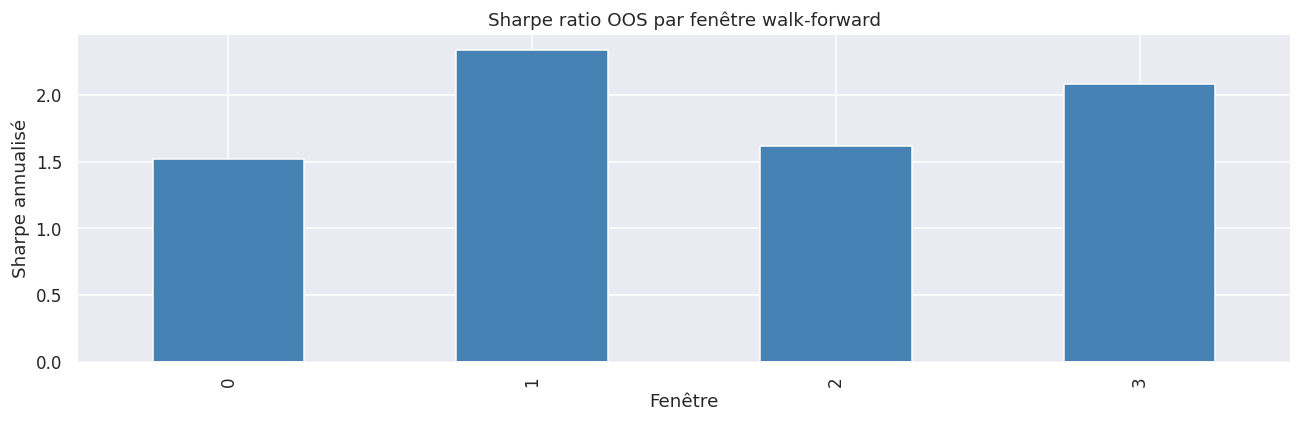

In [10]:
from walk_forward import run_walk_forward

wf = run_walk_forward(prices, train_years=5, test_years=1, max_pairs=3)

# PnL OOS concaténé
wf['combined_pnl'].cumsum().plot(
    title='PnL cumulé Out-of-Sample (walk-forward)',
    ylabel='PnL cumulé ($)', xlabel='Date', color='steelblue'
)
plt.tight_layout()
plt.savefig('../results/walk_forward_pnl.png', dpi=150)
plt.show()

# Sharpe par fenêtre
if 'sharpe' in wf['metrics_df'].columns:
    fig, ax = plt.subplots(figsize=(12, 4))
    wf['metrics_df']['sharpe'].plot(kind='bar', ax=ax, color='steelblue', edgecolor='white')
    ax.axhline(0, color='black', linewidth=1)
    ax.set_title('Sharpe ratio OOS par fenêtre walk-forward')
    ax.set_ylabel('Sharpe annualisé')
    ax.set_xlabel('Fenêtre')
    plt.tight_layout()
    plt.savefig('../results/walk_forward_sharpe.png', dpi=150)
    plt.show()